# CNN Vs LSTM - movie review sentiment Classification 


Current Model will try to improve Kim's solution :

[Kim's paper](http://www.aclweb.org/anthology/D14-1181) was published in 2014 and showed that not only are CNNs great for images but also text. With an extreamly simple architecture Kim outperformed all other models in 4 out of 7 benchmarks at the time. 

## Architecture

![Architecture diagram](https://imgur.com/Dsu7Q61.png)

*- architecture diagram taken from Kim's paper*

The architecture Kim used goes like this:

Firstly, sentences are represented as vectors of words and those words are converted into (300D) vectors giving us a 2D representation for each sentence. Kim uses a few different approaches for creating these word vectors:

- **CNN-rand**: where embeddings are randomly assigned to each word
- **CNN-static**: word2vec is used to provide word embeddings. Unknown words are randomly initialised. These embeddings are kept fixed.
- **CNN-non-static**: as above, but the vectors are fine-tuned (ie they can be changed) during training



He then performs convolutions on these 2D representations, but he does it in a way you don't see very often. Convolutions of different window sizes (3, 4 and 5) are performed on the representations directly and then max pooled. This is a little like an inception module in the Goog LeNet, but not something I've really seen anywhere else.

Finally after a layout of dropout, an output layer is directly used to do the predictions.









I'll Try to verify if we can improve accuracy results of the CNN model .
Moreover I'll test current architecture Vs LSTM model in terms of accuracy & run time 

# Imports

In [ ]:
import numpy as np 
import pandas as pd 
import os
print(os.listdir("../input"))

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from keras.models import Model
from keras.layers import *
from keras.utils.np_utils import to_categorical
import re

import matplotlib.pyplot as plt
%matplotlib inline

# Explore Data

In [ ]:
df = pd.read_csv('../input/movie-review-sentiment-analysis-kernels-only/train.tsv.zip', delimiter='\t')
df.head()

In [ ]:
#df = pd.read_csv('../input/movie-review-sentiment-analysis-kernels-only/train.tsv', delimiter='\t')
#df = df[['Phrase', 'Sentiment']]

pd.set_option('display.max_colwidth', -1)
df.head(10)

Our input data X is Pharse - we'll need to do some preprocessing beofre using it 
Our out data Y is Sentiment =[1,2,3,4,5] which represent 5 classes of moview reviews :
very negative, slightly negative, neutral, slightly positive and very positive


To clean Pharse I'll turn url's into `url`, remove anything that's not alphanumeric or a space. Then lowercase what's left.

In [ ]:
def clean_str(in_str):
    in_str = str(in_str)
    # replace urls with 'url'
    in_str = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})", "url", in_str)
    in_str = re.sub(r'([^\s\w]|_)+', '', in_str)
    return in_str.strip().lower()



In [ ]:
df['text'] = df['Phrase'].apply(clean_str)

Let's review clean data we'll use ('text')

In [ ]:
df.head(10)

# Unbalance dataset

Sadly our dataset isn't balanced, let's looks at the data and target a solution 

In [ ]:
df.Sentiment.value_counts()

Since we have many examples for a clean dataset i.e :

~35k samples we don't necessarily need to pose over/under sampling solutions here .
I'll just take more examples for each class while making sure 

Class0[Number of samples] > 0.3*Classx[Number of samples]


In [ ]:
df_0 = df[df['Sentiment'] == 0].sample(frac=1)
df_1 = df[df['Sentiment'] == 1].sample(frac=1)
df_2 = df[df['Sentiment'] == 2].sample(frac=1)
df_3 = df[df['Sentiment'] == 3].sample(frac=1)
df_4 = df[df['Sentiment'] == 4].sample(frac=1)

# we want a balanced set for training against - there are 7072 `0` examples
sample_size = 7072

data = pd.concat([df_0.head(sample_size), df_1.head(sample_size+8000), df_2.head(sample_size+10000), df_3.head(sample_size+6000), df_4.head(sample_size+2000)]).sample(frac=1)

Now, we need to tokenize our sentences into vectors. Before we do that we need to pick a vector size.

In [ ]:
data['l'] = data['text'].apply(lambda x: len(str(x).split(' ')))
print("mean length of sentence: " + str(data.l.mean()))
print("max length of sentence: " + str(data.l.max()))
print("std dev length of sentence: " + str(data.l.std()))

In [ ]:
# these sentences aren't that long so we may as well use the whole string
sequence_length = 51

In [ ]:
max_features = 25000 # this is the number of words we care about

tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
tokenizer.fit_on_texts(df['text'].values)

# this takes our sentences and replaces each word with an integer
X = tokenizer.texts_to_sequences(df['text'].values)

# we then pad the sequences so they're all the same length (sequence_length)
X = pad_sequences(X, sequence_length)

y = pd.get_dummies(df['Sentiment']).values

# where there isn't a test set, Kim keeps back 10% of the data for testing, I'm going to do the same since we have an ok amount to play with
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

print("test set size " + str(len(X_test)))

In [ ]:
X_train.shape

# Model 1: Random embeddings

I tired few types of models : 

	•light VGG16
	• Light Inception V3

In both of those cases model got overfit , even when trying to add overfit solutions (i.e regulations , dropout , increase number of data samples ,etc..) .I wasn't able to meet accuracy results comapared to single CNN layer.

In [ ]:
embedding_dim = 100 #Can try 50/100/200
num_filters = 50

inputs = Input(shape=(sequence_length,), dtype='int32')
# use a random embedding for the text
embedding_layer = Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=sequence_length)(inputs)
reshape = Reshape((sequence_length, embedding_dim, 1))(embedding_layer)
conv_0 = Conv2D(num_filters, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=regularizers.l1(1e-5))(reshape)
maxpool_0 = MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0)
flatten = Flatten()(maxpool_0)
dropout = Dropout(0.5)(flatten)
output = Dense(units=5, activation='softmax')(dropout)

Compared adadelta optimizer Vs adam optimizer, I got similar results but adadelta was much slower

In [ ]:
model = Model(inputs=inputs, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Change batch size - you can also try here 40 & 64
Split size - reduce to 0.1 to reduce overfit risk 

In [ ]:
batch_size = 32 
history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, verbose=1, validation_split=0.1, shuffle=True)

Let's plot the accuracy & loss

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Reduce overfit and improve results compared to complex CNN models 


In [ ]:
y_hat = model.predict(X_test)

In [ ]:
accuracy_score(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat)))

In [ ]:
confusion_matrix(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat)))

This is suprisingly good - a random model would achieve a score of ~0.2 (there are 5 classes)

# LSTM Model 

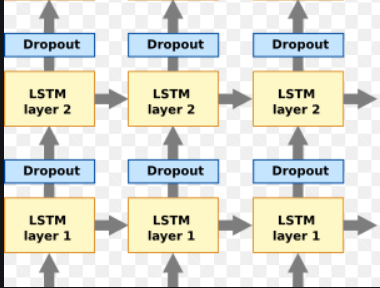

In LSTM model I also tried few approaches : 

1.tried to add more LSTM layers - didn't improve accuracy results while increase run time per epoch 
2.Tried to more FC layers - didn't improve accuracy results while increase run time per epoch 
3.Increase number of LSTM units per layer - minor improvement in test set but no improvement in test set + increase in run time 


In [ ]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.optimizers import Adam

In [ ]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=sequence_length))
model_lstm.add(LSTM(256, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
model_lstm.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5, return_sequences=False))
model_lstm.add(Dense(100, activation='relu'))
model_lstm.add(Dropout(0.4))
model_lstm.add(Dense(5, activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.005), metrics=['accuracy'])
model_lstm.summary()

In [ ]:
# fit
history = model_lstm.fit(X_train, y_train, epochs=4, batch_size=256, verbose=1, validation_split=0.1, shuffle=True)

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
y_hat_6 = model_lstm.predict(X_test)

In [ ]:
accuracy_score(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat_6)))

In [ ]:
confusion_matrix(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat_6)))

We got minor improvement compared to CNN model - the main difference is run time ~X3 slower compared to CNN


# Model 2: Static word2vec

Now rather than randomly assign vectors we're going use w2v embeddings.
Firstly, we need to load the model. Kaggle have a great 50/100/200D model trained using GloVe.

In [ ]:
embeddings_index = {}
f = open(os.path.join('../input/glove-global-vectors-for-word-representation', 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

In [ ]:
coefs.shape

In [ ]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

I run through all the words in tokenizer and look for them in the w2v model. If they exist we add them to our embedding matrix (ie our embeddings) if they don't then we assign a random vector (~1600 words wasn't found)

In [ ]:
num_words = min(max_features, len(word_index)) + 1
print(num_words)
non_exist_word_count=0
# first create a matrix of zeros, this is our embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))

# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # we found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    else:
        non_exist_word_count=non_exist_word_count+1     
        # doesn't exist, assign a random vector
        embedding_matrix[i] = np.random.randn(embedding_dim)
print('Count for non exist words in dict :',non_exist_word_count)

Then our model looks almost identical to the first model, except with a different embedding layer

In [ ]:
inputs_2 = Input(shape=(sequence_length,), dtype='int32')
embedding_layer_2 = Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=sequence_length,
                            trainable=False)(inputs_2)
reshape_2 = Reshape((sequence_length, embedding_dim, 1))(embedding_layer_2)
conv_0_2 = Conv2D(num_filters, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(1e-5))(reshape_2)
maxpool_0_2 = MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0_2)
flatten_2 = Flatten()(maxpool_0_2)
dropout_2 = Dropout(0.5)(flatten_2)
output_2 = Dense(units=5, activation='softmax')(dropout_2)

In [ ]:
model_2 = Model(inputs=inputs_2, outputs=output_2)
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_2.summary())

In [ ]:
batch_size = 32
history_2 = model_2.fit(X_train, y_train, epochs=8, batch_size=batch_size, verbose=1, validation_split=0.1, shuffle=True)

In [ ]:
plt.plot(history_2.history['acc'])
plt.plot(history_2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
y_hat_2 = model_2.predict(X_test)

In [ ]:
accuracy_score(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat_2)))

In [ ]:
confusion_matrix(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat_2)))

We can see lower accuracy results -which is expected since ~1600 words got randomize vectors 


# Model 3: w2v with trainable embeddings

For this model we're going to try the same model again, but this time make the embeddings trainable. That means if during training the model decides on a better embedding for a word then it'll update it

This has the added benifit of updating the words which were randomly assigned a vector (because they weren't in the w2v model)

In [ ]:
inputs_3 = Input(shape=(sequence_length,), dtype='int32')

embedding_layer_3 = Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=sequence_length,
                            trainable=True)(inputs_3)
reshape_3 = Reshape((sequence_length, embedding_dim, 1))(embedding_layer_3)
conv_0_3 = Conv2D(num_filters, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(1e-3))(reshape_3)
maxpool_0_3 = MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0_3)

flatten_3 = Flatten()(maxpool_0_3)

# do dropout and predict
dropout_3 = Dropout(0.5)(flatten_3)
output_3 = Dense(units=5, activation='softmax')(dropout_3)

In [ ]:
model_3 = Model(inputs=inputs_3, outputs=output_3)
model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_3.summary())

In [ ]:
batch_size = 32
history_3 = model_3.fit(X_train, y_train, epochs=8, batch_size=batch_size, verbose=1, validation_split=0.1, shuffle=True)

In [ ]:
plt.plot(history_3.history['acc'])
plt.plot(history_3.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
y_hat_3 = model_3.predict(X_test)

In [ ]:
accuracy_score(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat_3)))

In [ ]:
confusion_matrix(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat_3)))

# LSTM with trainable embedding 

Same LSTM model as before but with trainable embedding layer 

In [ ]:
model = Sequential()

model.add(Embedding(num_words,embedding_dim,
                              embeddings_initializer=Constant(embedding_matrix),
                            input_length=sequence_length,
                            trainable=True))
model.add(LSTM(256, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
model.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5, return_sequences=False))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.005), metrics=['accuracy'])
model.summary()

In [ ]:
history_5 = model.fit(X_train, y_train, epochs=8, batch_size=256, verbose=1, validation_split=0.1, shuffle=True)

In [ ]:
plt.plot(history_5.history['acc'])
plt.plot(history_5.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history_5.history['loss'])
plt.plot(history_5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
y_hat_5 = model.predict(X_test)

In [ ]:
accuracy_score(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat_5)))

In [ ]:
confusion_matrix(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat_5)))

# Conclusions

Here's the final results

In [ ]:
print("CNN random       : " + str(accuracy_score(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat)))))
print("CNN static       : " + str(accuracy_score(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat_2)))))
print("CNN trainable    : " + str(accuracy_score(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat_3)))))
print("LSTM             : " + str(accuracy_score(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat_6)))))
print("LSTM trainable   : " + str(accuracy_score(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat_5)))))


Compared to Kim paper I manage to improve accuracy but wasn't able to get the same behavior - i.e trainable embedding didn't improve results - My other suggestion here is to try using additional CNN layer in theory we should get small improvement . 

LSTM Vs CNN: 

LSTM got similar accuracy results to CNN model but CNN is much faster . 


In [ ]:
df2 = pd.read_csv('../input/movie-review-sentiment-analysis-kernels-only/test.tsv.zip', delimiter='\t')
df2['text'] = df2['Phrase'].apply(clean_str)

In [ ]:
df2.head(5)

In [ ]:
max_features = 25000 # this is the number of words we care about

tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
tokenizer.fit_on_texts(df2['text'].values)

# this takes our sentences and replaces each word with an integer
X_test_model = tokenizer.texts_to_sequences(df2['text'].values)

# we then pad the sequences so they're all the same length (sequence_length)
X_test_model = pad_sequences(X_test_model, sequence_length)

In [ ]:
# submit
y_pred = model_lstm.predict_classes(X_test_model)
submission = pd.read_csv('../input/movie-review-sentiment-analysis-kernels-only/sampleSubmission.csv')
submission.Sentiment = y_pred
submission.to_csv('submission.csv', index=False)

# Next steps : 

• Improve text clean up in preprocessing can help improve accuracy results 
• I saw many phrases which doesn't contain anything ( for example phrase='a') , again removing those unnecessary samples can also contribute to accuracy improvement 
•In theory deeper model should outperform my current model - In order to do so suggestion is to extract more phrases (add 

# acknowledgements

thanks to Yoon Kim for writing such a [detailed and approachable paper](http://www.aclweb.org/anthology/D14-1181). 
Also huge thanks to Hamish https://www.kaggle.com/hamishdickson for notebook wrapper . 